# Quantum Terrain Generation

This notebook contains a stripped down version of the one embedded in [this blog post](https://medium.com/qiskit/creating-infinite-worlds-with-quantum-computing-5e998e6d21c2). See that article for information on what everything does, and why.

For this notebook we will need various helper functions. These can all be found in the giant cell below.

Just run it and move on.

In [1]:
from PIL import Image
from IPython.display import display
import random
import numpy as np
import ipywidgets as widgets
from ipywidgets import Checkbox, ToggleButton, Layout, HBox, VBox
from qiskit import *
import time

try:
    IBMQ.load_accounts()
except:
    pass


def height2image (Z, terrain=None ):
    # converts a heightmap z into a PIL image
    # for terrain=None, this is a black and white image with white for Z[x,y]=1 and black for Z[x,y]=0
    # otherwise, the values in terrain are used as thresholds between sea and beach, beach and grass, etc
    image = {}
    for pos in Z:
        if terrain:
            if Z[pos]<terrain[0]:
                image[pos] = (50,120,200)
            elif Z[pos]<terrain[1]:
                image[pos] = (220,220,10)
            elif Z[pos]<terrain[2]:
                image[pos] = (100,200,0)
            elif Z[pos]<terrain[3]:
                image[pos] = (75,150,0)
            elif Z[pos]<terrain[4]:
                 image[pos] = (200,200,200)  
            else:
                image[pos] = (255,255,255)
        else:
            z = int(255*Z[pos])
            image[pos] = (z,z,z)
            
    X = max(Z.keys())[0]+1
    Y = max(Z.keys())[1]+1
    img = Image.new('RGB',(X,Y))  
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            img.load()[x,y] = image[x,y]
    return img

def plot_height (Z,terrain=[5/16,6/16,9/16,12/16,14/16],zoom=None):
    # display a heightmap as the above image
    # displayed image is a terrain map by default
    img = height2image(Z,terrain=terrain)
    if zoom:
        img = img.resize((zoom*img.size[0],zoom*img.size[0]), Image.ANTIALIAS)
    img.save('temp.png')
    display(Image.open('temp.png'))
    
def get_L(n):
    # determine the size of the grid corresponding to n qubits
    Lx = int(2**np.ceil(n/2))
    Ly = int(2**np.floor(n/2))
    return [Lx,Ly]

def make_grid(n):
    # make a dictionary for which every point in the grid is assigned a unique n bit string
    # these are such that '0'*n is in the center, and each string neighbours only its neighbours on the hypercube
    
    [Lx,Ly] = get_L(n)

    strings = {}
    for y in range(Ly):
        for x in range(Lx):
            strings[(x,y)] = ''

    for (x,y) in strings:
        for j in range(n):
            if (j%2)==0:
                xx = np.floor(x/2**(j/2))
                strings[(x,y)] = str( int( ( xx + np.floor(xx/2) )%2 ) ) + strings[(x,y)]
            else:
                yy = np.floor(y/2**((j-1)/2))
                strings[(x,y)] = str( int( ( yy + np.floor(yy/2) )%2 ) ) + strings[(x,y)]

    center = '0'*n
    current_center = strings[ ( int(np.floor(Lx/2)),int(np.floor(Ly/2)) ) ]
    diff = ''
    for j in range(n):
        diff += '0'*(current_center[j]==center[j]) + '1'*(current_center[j]!=center[j])
    for (x,y) in strings:
            newstring = ''
            for j in range(n):
                newstring += strings[(x,y)][j]*(diff[j]=='0') + ('0'*(strings[(x,y)][j]=='1')+'1'*(strings[(x,y)][j]=='0'))*(diff[j]=='1')
            strings[(x,y)] = newstring
            
    grid = {}
    for y in range(Ly):
        for x in range(Lx):
            grid[strings[(x,y)]] = (x,y)
    
    return strings

def normalize_height(Z):
    # scales heights so that the maximum is 1 and the minimum is 0
    maxZ = max(Z.values())
    minZ = min(Z.values())
    for pos in Z:
        Z[pos] = (Z[pos]-minZ)/(maxZ-minZ)
    return Z

def counts2height(counts,grid,log=False):
    # set the height of a point to be the counts value of the corresponding bit string (or the logarithm) and normalize
    Z = {}
    for pos in grid:
        try:
            Z[pos] = counts[grid[pos]]
        except:
            Z[pos] = 0
    if log:
        for pos in Z:
            Z[pos] = max(Z[pos],1/len(grid)**2)
            Z[pos] = np.log( Z[pos] )/np.log(2)
    Z = normalize_height(Z)    
    return Z

def height2state(Z,grid):
    # converts a heightmap intp a quantum state
    N = len(grid)
    state = [0]*N

    for pos in Z:
        state[ int(grid[pos],2) ] = np.sqrt( Z[pos] ) # amplitude is square root of height value
    R = sum(np.absolute(state)**2)
    state = [amp / np.sqrt(R) for amp in state] # amplitudes are normalized
    return state

def state2counts (state,shots=None):
    N = len(state)
    n = int(np.log2(N))
    if shots is None:
        shots = N**2
    counts = {}
    for j in range(N):
        string = bin(j)[2:]
        string = '0'*(n-len(string)) + string
        counts[string] = np.absolute(state[j])**2 * shots # square amplitudes to get probabilities
    return counts

def get_boxes(L,value=True):

    width = str(500/L[0])+'px'
    height = str(500/L[1])+'px'

    box = {}
    for y in range(L[1]):
        for x in range(L[0]):
            if value=='sea':
                this_value = ( (x in [0,L[0]-1]) or (y in [0,L[1]-1]) )
            elif value=='mountain':
                this_value = not ( (x in [int(L[0])/2,int(L[0])/2-1]) and (y in [int(L[1])/2,int(L[1])/2-1]) )
            else:
                this_value = value
            box[x,y] = widgets.ToggleButton(value=this_value,button_style='',layout=Layout(width=width, height=height))
            
    return box

def flat_height(L):
    # create height map that is 0 everywhere
    Z ={}
    for x in range(L[0]):
        for y in range(L[1]):
            Z[x,y] = 0
    return Z

def shuffle_grid(grid):
    
    n = int( np.log(len(grid))/np.log(2) )
    
    order = [j for j in range(n)]
    random.shuffle(order)
    
    new_grid = {}
    for pos in grid:
        new_string = ''
        for j in order:
            new_string = grid[pos][j] + new_string
        new_grid[pos] = new_string
    
    return new_grid

def shuffle_height (Z,grid):
    
    new_grid = shuffle_grid(grid)
    new_Z = {}
    for pos in Z:
        string = grid[pos] 
        new_pos = list(new_grid.keys())[ list(new_grid.values()).index( string ) ]
        new_Z[new_pos] = Z[pos]
        
    return new_Z,new_grid
        
def rotate_height (Z,theta):
    # rotate height Z by angle theta
    L = list(max(Z))
    mid = [(L[j]+1)/2 for j in range(2)]
    
    Lr = [ int( 1.6*(L[j]+1) ) for j in range(2) ]
    midr = [Lr[j]/2 for j in range(2)]
    
    Zr = flat_height(Lr)
    
    for pos in Zr:
        
        d = [ pos[j]-midr[j] for j in range(2) ]
        
        x = int( d[0]*np.cos(theta*np.pi) + d[1]*np.sin(theta*np.pi) + mid[0] )
        y = int( -d[0]*np.sin(theta*np.pi) + d[1]*np.cos(theta*np.pi) + mid[1] )
        
        if (x,y) in Z:
            Zr[pos] = Z[x,y]
        else:
            Zr[pos] = 0
        
    return Zr

def blur(Zs,reduced_size,steps=2):
    for j in range(steps):
        for offset in [0,1]:
            for y in range(1,reduced_size[1]-1):
                for x in range(1+(offset+y)%2,reduced_size[0]-1+(offset+y)%2,2):
                    Zs[x,y] = ( Zs[x,y] + (Zs[x+1,y] + Zs[x-1,y] + Zs[x,y+1] + Zs[x,y-1])/4 )/2
    return Zs

def islands(size,Zs,tartans):
    # height map of created by combining the quantum tartans of `tartans` with the basic map features.
    Z = flat_height(size)
        
    tsize = max(tartans[0])
    
    for tartan in tartans:  
        unchosen = True
        while unchosen:
            x0 = random.choice(range(size[0]))
            y0 = random.choice(range(size[1]))
            if random.random()<Zs[int(x0*(max(Zs.keys())[0]+1)/size[0]),int(y0*(max(Zs.keys())[1]+1)/size[1])]:
                unchosen = False

        for (x,y) in tartan:
            xx = x-int(tsize[0]/2)+x0
            yy = y-int(tsize[1]/2)+y0
            if (xx,yy) in Z:
                    Z[xx,yy] += tartan[x,y]
                
    Z = normalize_height(Z)

    return Z

def make_blocks(Z,terrain=[2/16,3/16,5/16,10/16,12/16],height=24,depth=12):
    # make a dictionary that determines which material exists at each 3D position
    # also returns mins and maxs of all three coordinates in `mins` and `maxs`
    def addBlocks( blocks, x1,h1,y1, x2,h2,y2, block ):
        # add a blocks of a given type for a given range of coordinates
        for x in range(x1,x2+1):
            for y in range(y1,y2+1):
                for h in range(h1,h2+1):
                    blocks[x,h,y] = block
    
    def addTreeBlocks( blocks, x,h,y, rnd ):
        #Makes a tree, rooted at the specified position'''
        for j in range(1,6):
            blocks[x,h+j,y] = 'tree'
        for xx in range(x-3,x+4):
            for yy in range(y-3,y+4):
                for hh in range(h+5,h+11):
                    d = (xx-x)**2+(yy-y)**2+(hh-h-6)**2 + 0.1
                    if d<8:
                        blocks[xx,hh,yy] = 'leaves'
        xx = choose([x-1,x+1],rnd)
        yy = choose([y-1,y+1],rnd)
        blocks[xx,h+5,yy] = 'tree'
        blocks[xx,h+4,yy] = 'torch'
                              
    def choose( options, rnd ):
        return options [ int(round(rnd*( len(options)-1 ))) ]
    
    
    sea_level = int( depth+terrain[0]*height+1 )
    
    choosing = True
    while choosing:
        spawn = random.choice( list(Z.keys()) )
        if Z[spawn]>terrain[0]:
            choosing = False
    spawn = [spawn[0],depth+height,spawn[1]]
    
    blocks = {}
    (Xmin,Hmin,Ymin) = (0,0,0)
    (Xmax,Hmax,Ymax) = (0,0,0)
    for (X,Y) in Z:
        
        Hfloat = depth + Z[X,Y]*height
        H = int( Hfloat ) # height for a block
        rnd = Hfloat-H # value from 0 to 1 that we can use for randomness
        
        Xmin = min(Xmin,X); Ymin = min(Ymin,Y); Hmin = min(Hmin,H)
        Xmax = max(Xmax,X); Ymax = max(Ymax,Y); Hmax = max(Hmax,H)
        
        # First we make a cavern, which is most spacious under hills
        
        Hm = int( (1-Z[X,Y])*depth/2 ) # height for stalagtites
        Ht = int( depth - (1-Z[X,Y])*depth/2 ) #height at which stalagmites begin
        
        if Z[X,Y]<terrain[0]:
            minerals = ['diamondblock','goldblock'] # most precious minerals in hard to reach places
        else:
            minerals = ['stone','stone','stone_with_coal','stone_with_iron','stone_with_copper','stone_with_tin','stone_with_gold','stone_with_diamond']
        stone_m = choose(minerals,rnd)
        stone_t = choose(minerals,1-rnd)
   
        if (1-Z[X,Y])<terrain[0]: # the very bottom of the cavern has lava
            blocks[X,0,Y] = stone_m
            blocks[X,1,Y] = 'lava_source'
        else: # otherwise a mineral
            addBlocks( blocks, X,0,Y, X,Hm,Y, stone_m )
            
        if Z[X,Y]<terrain[4]: # the roof is always a mineral
            addBlocks( blocks, X,Ht,Y, X,depth,Y, stone_t )
        
        if rnd<0.005 and Z[X,Y]>terrain[0] and Z[X,Y]<terrain[4]:
            blocks[X,Ht-1,Y] = 'torch'
                        
        if Z[X,Y]<terrain[0]: # sand at H and then water up to sea level
            addBlocks( blocks, X,depth,Y, X,H,Y, 'sand' )
            addBlocks( blocks, X,H+1,Y, X,sea_level,Y, 'water_source' )
        elif Z[X,Y]<terrain[1]: # sand
            addBlocks( blocks, X,depth+1,Y, X,H-1,Y, 'stone' )
            blocks[X,H,Y] = 'sand'
            blocks[X,H+1,Y] = 'sand'
        elif Z[X,Y]<terrain[2]: # grass with trees
            addBlocks( blocks, X,depth+1,Y, X,H-1,Y, 'stone' )
            blocks[X,H,Y] = 'dirt_with_grass'
            blocks[X,H+1,Y] = 'dirt_with_grass'
            if rnd<0.025:
                addTreeBlocks( blocks, X,H,Y, rnd )
            else:
                blocks[X,H+2,Y] = choose(['fern_1','marram_grass_1','marram_grass_2','marram_grass_3'],rnd)
        elif Z[X,Y]<terrain[3]: # grass with ferns
            addBlocks( blocks, X,depth+1,Y, X,H-1,Y, 'stone' )
            blocks[X,H,Y] = 'dirt_with_grass'
            blocks[X,H+1,Y] = 'dirt_with_grass'
            blocks[X,H+2,Y] = choose(['fern_1','fern_2','fern_3','marram_grass_1'],rnd)
        elif Z[X,Y]<terrain[4]: # mixture of grass and stone
            addBlocks( blocks, X,depth+1,Y, X,H-1,Y, 'stone' )
            if rnd<1/3:
                blocks[X,H,Y] = 'dirt_with_grass'
                blocks[X,H+1,Y] = 'dirt_with_grass'
            else:
                blocks[X,H,Y] = 'stone'
                blocks[X,H+1,Y] = 'stone'
        elif H==(depth + terrain[4]*height): # just stone, with a random bit of additional height
            H += int(height*rnd/10)
            addBlocks( blocks, X,depth+1,Y, X,H+1,Y, 'stone' )
        elif Z[X,Y]==1:
            blocks[X,H,Y] = 'torch'
                
        mins = (Xmin,Hmin,Ymin)
        maxs = (Xmax,Hmax,Ymax)
        
    return blocks, spawn, mins, maxs
    
def save_blocks(blocks,spawn,mins,maxs,filename='blocks.csv'):
    # saves a dictionary of the form created by the above function as a csv file
    with open(filename, 'w') as file:
        file.write( str(mins[0])+','+str(mins[1])+','+str(mins[2])+',min,\n' )
        file.write( str(maxs[0])+','+str(maxs[1])+','+str(maxs[2])+',max,\n' )
        file.write( str(spawn[0])+','+str(spawn[1])+','+str(spawn[2])+',player,\n' )
        for (x,h,y) in blocks:
            file.write( str(x)+','+str(h)+','+str(y)+','+blocks[x,h,y]+',\n' )

def quantum_tartan (seed,theta,grid=None,shots=1,log=True):
        
    n = int(np.log2( len(seed) ))
        
    if grid is None:
        grid = make_grid(n)

    state = height2state(seed,grid)

    q = QuantumRegister(n)
    qc = QuantumCircuit(q)
    qc.initialize(state,q)
    qc.ry(2*np.pi*theta,q)
    
    if shots>1:
        try:
            backend = IBMQ.get_backend('ibmq_16_melbourne')
        except:
            backend = Aer.get_backend('qasm_simulator')
    else:
        backend = Aer.get_backend('statevector_simulator')

    if shots>1:
        c = ClassicalRegister(n)
        qc.add_register(c)
        qc.measure(q,c)
    
    start = time.time()
    print('Quantum job initiated on',backend.name())
    job = execute(qc, backend, shots=shots)
    end = time.time()
    print('Quantum job complete after',int(end-start),'seconds')
    

    if shots>1:
        counts = job.result().get_counts()
    else:
        counts = state2counts( job.result().get_statevector() )
        
    Z = counts2height(counts,grid,log=log)   
    
    return Z, grid

In this notebook we will generate some terrain.

There are many ways to do this, but all can generally be thought of as having two stages.
1. Work out the broad features, such as where the mountains and the sea will go.
2. Add interesting texture and features on top of this.

The standard method is to do this by many layers of gradient noise. Here we'll do something different: a collaboration between a human and quantum computation.

First you need decide where you want the mountains in your terrain to be. Put some white points in the map below where you want high ground to be. The more points you put in an area, the higher the ground.

In [2]:
reduced_size = [10,10]
peak_box = get_boxes(reduced_size,value='mountain')
VBox([ HBox([ peak_box[x,y] for x in range(reduced_size[0]) ]) for y in range(reduced_size[1]) ])

Now choose where you want low ground to be (under or close to sea-level).

In [3]:
valley_box = get_boxes(reduced_size,value='sea')
VBox([ HBox([ valley_box[x,y] for x in range(reduced_size[0]) ]) for y in range(reduced_size[1]) ])

Your inputs give us the following, very basic map.

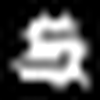

In [4]:
Zs = {}
for y in range(reduced_size[1]):
    for x in range(reduced_size[0]):
        if peak_box[x,y].value==False:
            Zs[x,y] = 1
        elif valley_box[x,y].value==True:
            Zs[x,y] = 0
        else:
            Zs[x,y] = 0.5
            
plot_height( Zs , terrain=None, zoom=10 )

You can apply a blur on this to smooth it out, if you want.

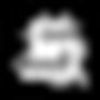

In [5]:
Zs = blur(Zs,reduced_size,steps=1)
plot_height( Zs , terrain=None, zoom=10 )

Next, we need to create the textures that we will overlay onto the map. For this you need provide a seed for the quantum computer to work with. This will be a simple image that can be manipulated using quantum effects. Draw one below, by clicking on pixels to switch them between black and white.

In [6]:
n = 6
shots = 4**n
L = get_L(n)

box = get_boxes(L)

VBox([ HBox([ box[x,y] for x in range(L[0]) ]) for y in range(L[1]) ])

Here's the image you created.

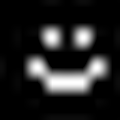

In [7]:
Z = flat_height(L)
for y in range(L[1]):
    for x in range(L[0]):
        if box[x,y].value==False:
            Z[x,y] = 1
            
plot_height( Z, terrain=None, zoom=15 )

Now we'll run it through a quantum interference process.

Quantum job initiated on qasm_simulator
Quantum job complete after 0 seconds


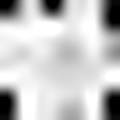

In [9]:
Z, grid = quantum_tartan(Z,0.05,shots=shots)
plot_height( Z, terrain=None, zoom=15 )

This new image will be used as the basis for textures within the landscape. This means that it is is good for it to be nicely bumpy, rather than have lots of extremes of highs and lows. So run the above process until the result is doesn't have lots of pure black or white.

Once this is done, we create many variants of this basic texture using the process below.

In [10]:
start = time.time()

samples = 2000
tartans = []
for j in range(samples):
    randZ,_ =  shuffle_height(Z,grid)
    randZ = rotate_height(randZ,random.random())
    tartans.append( randZ )
    
end = time.time()
print('Generation of',samples,'samples took',int(end-start),'seconds')

Generation of 2000 samples took 2 seconds


Now we can get our map. The broad features you supplied will be combined with the many quantum texture patches. The end result will be some nice terrain.

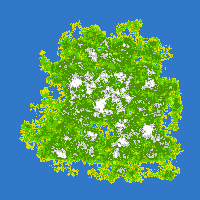

In [11]:
size = [200,200]
Z_islands = islands(size,Zs,tartans)
plot_height( Z_islands, terrain=[2/16,3/16,5/16,8/16,10/16] )

The final step is to save the map. This creates a csv file which can be used with the csv2terrain mod of Minetest.

In [12]:
blocks, spawn, mins, maxs = make_blocks( Z_islands )
save_blocks( blocks, spawn, mins, maxs )